Nome: Larissa Rafaela Rodrigues Nepomuceno - RA: 10391039

# **Fluxo Óptico - Cálculo de velocidade e direção de movimento**
A técnica de fluxo óptico é utilizada para medir a velocidade de deslocamento de um objeto virtual em quadros consecutivos, como o deslocamento de pixels entre vários frames de um vídeo. Além de calcular a veloridade e direção de deslocamento, esta técnica também pode ser utilizada ao detectar movimento em um vídeo, auxiliando em tarefas de monitoramento apresentada no próxinmo tópico do notebook.
O método Lucas Kanade é um dos métodos utilizados para estimativa de fluxo óptico, desenvolvido por Bruce D. Lucas e Takeo Kanade. A ideia principal é que o movimento dos pixels seja constante em uma área pequena ao redor de cada pixel. O método resolve equações matemáticas para determinar o movimento dos pixels utilizando um critério de mínimos quadrados, encontrando a melhor estimativa possível do movimento dentro dessa área local.

O objetivo do fluxo óptico é determinar um vetor [u, v] para cada pixel na imagem. Esse vetor indica a velocidade com que o pixel se move pela imagem e em qual direção ele está se movendo. Em um contexto mais amplo, um ponto qualquer P na cena é mapeado para um ponto p[x, y] no sistema de coordenadas da câmera [X, Y, Z], onde o eixo óptico aponta na direção de z. O movimento da câmera é caracterizado por sua rotação [Ωx, Ωy, Ωz] e translação [Tx, Ty, Tz].


O vídeo utilizado nos códigos está disponível abaixo:

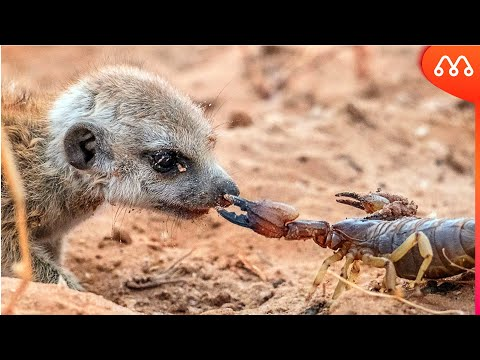

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('cPcBl2r2sM4')

Exemplo de cálculo de velocidade e direção utilizando opencv e passo a passo descrito em comentários:

In [14]:
import cv2
import numpy as np
from pytube import YouTube

# leitura do vídeo escolhido
youtube_url = 'https://www.youtube.com/watch?v=ssSCGwy_Qfo'
yt = YouTube(youtube_url)
stream = yt.streams.filter(file_extension='mp4', res='360p').first()
stream.download(filename='video.mp4')

video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

# subtação de fundo - inicialização
fgbg = cv2.createBackgroundSubtractorMOG2()

# objeto de fluxo óptico
# winsize: Mapeia uma área de 15x15 pixels ao redor do ponto definido
# maxlevel: Define nível do algoritmo: quanto menor a janela, menos pixeis e melhor a detecção do fluxo óptico
# criteria: Específica os critérios de finalização e iterações do algoritmo de pesquisa iterativa

lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

if not cap.isOpened():
    print("Erro ao abrir o vídeo")
else:
    # leitura de frames iniciais
    for _ in range(30):
        ret, _ = cap.read()
        if not ret:
            break

    # ler o primeiro frame após estabilização
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=7, blockSize=7)

    ret, frame = cap.read()
    if ret:
        # aplicar subtração de fundo para detectar movimento
        fgmask = fgbg.apply(frame)

        # calcular fluxo óptico usando o método Lucas-Kanade
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)

        # selecionar pontos que retornaram o fluxo
        good_new = next_pts[status == 1]
        good_old = prev_pts[status == 1]

        # calcular a direção e a velocidade do movimento
        movements = []
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            dx, dy = new.ravel() - old.ravel()
            direction = np.arctan2(dy, dx) * 180 / np.pi  # convertendo para graus
            velocity = np.sqrt(dx**2 + dy**2)
            if velocity > 0:  # considerar apenas movimentos com velocidade significativa
                movements.append((new.ravel(), direction, velocity))

        print(f"{'Pixel Coordenadas':<25} {'Direção (graus)':<20} {'Velocidade':<10}")
        print("="*55)
        for (coords, direction, velocity) in movements:
            coords_str = f"[{coords[0]:.2f}, {coords[1]:.2f}]"
            print(f"{coords_str:<25} {direction:<20.2f} {velocity:<10.2f}")

cap.release()
cv2.destroyAllWindows()


Pixel Coordenadas         Direção (graus)      Velocidade
[213.00, 108.00]          57.92                0.00      
[247.00, 96.00]           -16.70               0.00      
[169.00, 121.00]          -161.57              0.00      
[335.00, 270.00]          10.07                0.00      
[412.00, 177.00]          180.00               0.00      
[412.00, 229.00]          -153.43              0.00      
[420.00, 183.00]          -90.00               0.00      
[404.00, 191.00]          -161.57              0.00      
[423.00, 213.00]          -170.54              0.00      
[401.00, 203.00]          116.57               0.00      
[412.00, 193.00]          -74.05               0.00      
[452.00, 213.00]          42.30                0.01      
[428.00, 226.00]          161.57               0.00      
[421.00, 191.00]          90.00                0.00      
[188.00, 116.00]          -158.75              0.00      
[409.00, 211.00]          12.80                0.00      
[405.00, 179.0

O resultado mostra uma tabela contendo as coordenadas dos pixels seguidos de sua direção e velocidade de deslocamento

## **Detecção de movimento**
 Para detectar objetos em movimento, é comum adotar uma estratégia que começa identificando o background, ou seja, o plano de fundo que representa o que não é relevante. Em seguida, esse background é subtraído das imagens sequenciais para revelar o foreground, que é o primeiro plano contendo as informações de interesse. Essa abordagem de subtração/remoção de fundo permite isolar e identificar os objetos que estão se movendo em relação ao ambiente estático ao fundo.
 O princípio da detecção de movimento consiste em comparar frames consecutivos, subtraindo os pixels de uma imagem pelo correspondente na outra. Isso resulta em uma imagem onde os pixels que permaneceram iguais se anulam, deixando visíveis apenas as áreas onde ocorreram mudanças/movimento.


Exemplo de detecção de movimento utilizando opencv com passo a passo descrito nos comentários do código:

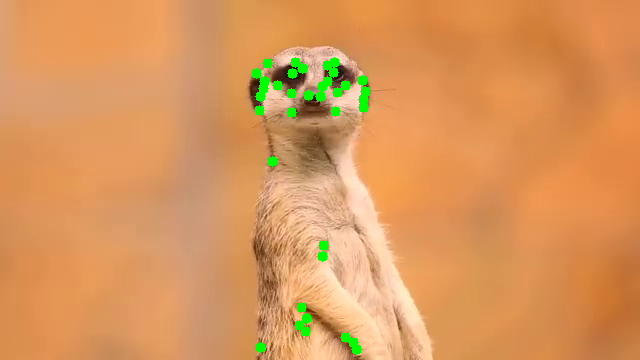

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from pytube import YouTube

# leitura do vídeo escolhido
youtube_url = 'https://www.youtube.com/watch?v=cPcBl2r2sM4'
yt = YouTube(youtube_url)
stream = yt.streams.filter(file_extension='mp4', res='360p').first()
stream.download(filename='video.mp4')

video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

# subtação de fundo - inicialização
fgbg = cv2.createBackgroundSubtractorMOG2()

# objeto de fluxo óptico
# winsize: Mapeia uma área de 15x15 pixels ao redor do ponto definido
# maxlevel: Define nível do algoritmo: quanto menor a janela, menos pixeis e melhor a detecção do fluxo óptico
# criteria: Específica os critérios de finalização e iterações do algoritmo de pesquisa iterativa

lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

if not cap.isOpened():
    print("Erro ao abrir o vídeo")
else:
    # leitura de frames iniciais
    for _ in range(30):
        ret, _ = cap.read()
        if not ret:
            break

    # ler primeiro frame após estabilização
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

    ret, frame = cap.read()
    if ret:
        # aplicar a subtração de fundo para detectar movimento
        fgmask = fgbg.apply(frame)

        # calcular o fluxo óptico usando o método Lucas-Kanade
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)

        # selecionar pontos que retornaram o fluxo
        good_new = next_pts[status == 1]
        good_old = prev_pts[status == 1]

        # desenhar linhas de fluxo no frame
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel().astype(int)
            c, d = old.ravel().astype(int)
            frame = cv2.line(frame, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)

        # exibir o frame com as linhas de fluxo
        cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()


O código imprime um frame do vídeo com as linhas/pontos de fluxo, elas representam onde foi encontrado movimento, não estando presentes no fundo da imagem.

# **Referências:**
- https://pytube.io/en/latest/user/streams.html
- https://www.youtube.com/watch?v=cPcBl2r2sM4
- https://www.peteletricaufu.com.br/static/ceel/doc/artigos/artigos2014/ceel2014_artigo051_r01.pdf
- https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/?source=post_page-----aa6302630f7c--------------------------------
- https://estevestoni.medium.com/rastreamento-por-fluxo-%C3%B3ptico-com-opencv-aa6302630f7c
- https://herisonassuncao.medium.com/detec%C3%A7%C3%A3o-de-movimento-com-python-e-opencv-c7323e2980ed
- https://iaexpert.academy/2021/06/07/subtracao-background-deteccao-movimento-videos/